In [ ]:
import pandas as pd
import numpy as np
import os
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

gc.collect()

11942

In [131]:
# Load Data
if not os.path.exists("sp500.csv"):
    raise FileNotFoundError("sp500.csv not found. Make sure the file is in the directory.")

sp500 = pd.read_csv("sp500.csv")
sp500['Date'] = pd.to_datetime(sp500['Date'], errors='coerce', utc=True)
sp500.set_index("Date", inplace=True)

# Data Cleaning and Processing
sp500.drop(columns=[col for col in ["Dividends", "Stock Splits"] if col in sp500.columns], inplace=True)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
# Add technical indicators
sp500["SMA_10"] = sp500["Close"].rolling(window=10).mean()
sp500["SMA_50"] = sp500["Close"].rolling(window=50).mean()
sp500["RSI_14"] = 100 - (100 / (1 + sp500["Close"].diff().apply(lambda x: max(x, 0)).rolling(window=14).mean() / sp500["Close"].diff().apply(lambda x: abs(x)).rolling(window=14).mean()))
exp1 = sp500["Close"].ewm(span=12, adjust=False).mean()
exp2 = sp500["Close"].ewm(span=26, adjust=False).mean()
sp500["MACD"] = exp1 - exp2
sp500["EMA_20"] = sp500["Close"].ewm(span=20, adjust=False).mean()
sp500["EMA_50"] = sp500["Close"].ewm(span=50, adjust=False).mean()
sp500["Bollinger_Upper"] = sp500["Close"].rolling(20).mean() + 2 * sp500["Close"].rolling(20).std()
sp500["Bollinger_Lower"] = sp500["Close"].rolling(20).mean() - 2 * sp500["Close"].rolling(20).std()

# Remove NaN values from indicators
sp500.dropna(inplace=True)

sp500.index = pd.to_datetime(sp500.index, errors='coerce', utc=True).tz_localize(None)
sp500 = sp500.loc[pd.Timestamp("1990-01-01"):].copy()

# Convert to NumPy array
data = sp500.values 

# Define time steps (e.g., 10 for a sequence of 10 steps)
time_steps = 10

# Reshape data to (samples, timesteps, features)
num_samples = data.shape[0] // time_steps  # Ensure it is divisible
num_features = data.shape[1]  # Number of features per time step

X = data[:num_samples * time_steps].reshape(num_samples, time_steps, num_features)

# Splitting Data: Training (before 2024), Testing (2024-2025)
train_df = sp500[sp500.index.year < 2024].copy()
test_df = sp500[sp500.index.year >= 2024].copy()

print("Training period: {} to {}".format(train_df.index.min().date(), train_df.index.max().date()))
print("Testing period: {} to {}".format(test_df.index.min().date(), test_df.index.max().date()))

Training period: 1990-01-02 to 2023-12-29
Testing period: 2024-01-02 to 2025-02-27


In [132]:
# Random Forest Model
predictors = ["Close", "Volume", "Open", "High", "Low", "SMA_10", "SMA_50", "RSI_14", "MACD", "EMA_20", "EMA_50", "Bollinger_Upper", "Bollinger_Lower"]
from xgboost import XGBClassifier
rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=20, max_depth=10, random_state=1)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=10, eval_metric='logloss')
xgb_model.fit(train_df[predictors], train_df["Target"])
# Remove initial full dataset training; training happens inside backtest

def predict(test, model, predictors):
    preds = model.predict_proba(test[predictors])[:, 1]
    preds = (preds >= 0.6).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    return pd.concat([test["Target"], preds], axis=1)

def backtest(data, model, predictors, start=1000, step=250):
    import time
    all_predictions = []
    total_steps = (data.shape[0] - start) // step
    for i, progress in enumerate(range(start, data.shape[0], step), 1):
        print(f"Processing step {i}/{total_steps}...")
        start_time = time.time()
        train = data.iloc[:progress].copy()  
        test = data.iloc[progress:progress + step].copy()
        if 'Target' not in test.columns:
            test['Target'] = data['Target'].iloc[progress:progress + step]  
        model.fit(train[predictors], train['Target'])  
        predictions = predict(test, model, predictors)
        all_predictions.append(predictions)
        print(f"Step {i}/{total_steps} completed in {time.time() - start_time:.2f} seconds.")
    return pd.concat(all_predictions)
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

rf_predictions = backtest(sp500, rf_model, predictors)
print("Random Forest Precision Score:", precision_score(rf_predictions["Target"], rf_predictions["Predictions"]))

Processing step 1/31...
Step 1/31 completed in 1.06 seconds.
Processing step 2/31...
Step 2/31 completed in 1.25 seconds.
Processing step 3/31...
Step 3/31 completed in 1.67 seconds.
Processing step 4/31...
Step 4/31 completed in 1.89 seconds.
Processing step 5/31...
Step 5/31 completed in 2.00 seconds.
Processing step 6/31...
Step 6/31 completed in 2.13 seconds.
Processing step 7/31...
Step 7/31 completed in 2.28 seconds.
Processing step 8/31...
Step 8/31 completed in 2.55 seconds.
Processing step 9/31...
Step 9/31 completed in 2.85 seconds.
Processing step 10/31...
Step 10/31 completed in 3.00 seconds.
Processing step 11/31...
Step 11/31 completed in 3.16 seconds.
Processing step 12/31...
Step 12/31 completed in 3.43 seconds.
Processing step 13/31...
Step 13/31 completed in 3.66 seconds.
Processing step 14/31...
Step 14/31 completed in 4.05 seconds.
Processing step 15/31...
Step 15/31 completed in 4.19 seconds.
Processing step 16/31...
Step 16/31 completed in 4.92 seconds.
Processing

In [133]:
# LSTM Model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[predictors])
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(train_df[['Target']])
test_scaled = scaler.transform(test_df[predictors])
y_test_scaled = target_scaler.transform(test_df[['Target']])

def create_sequences(data, target, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(target[i+window])
    return np.array(X), np.array(y)

window = 60
X_train, y_train = create_sequences(train_scaled, y_train_scaled.flatten(), window)
X_test, y_test = create_sequences(test_scaled, y_test_scaled.flatten(), window)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(predictors))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(predictors))

lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window, len(predictors))),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
y_pred_scaled = lstm_model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()  

Epoch 1/100


c:\Users\AhmedBafuleh\Documents\GitHub\ai-ml-with-python-and-knime-2024\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5279 - loss: 0.6929
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5279 - loss: 0.6922
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5388 - loss: 0.6910
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.5301 - loss: 0.6927
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5362 - loss: 0.6907
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5261 - loss: 0.6919
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5355 - loss: 0.6913
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5333 - loss: 0.6911
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5324 - loss: 0.6911
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5317 - loss: 0.6916
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5369 - loss: 0.6907
Epoch 12/100
133/133 ━━━━━━━━━━━━━━━━━━━━

Ensemble Model Precision Score: 0.0


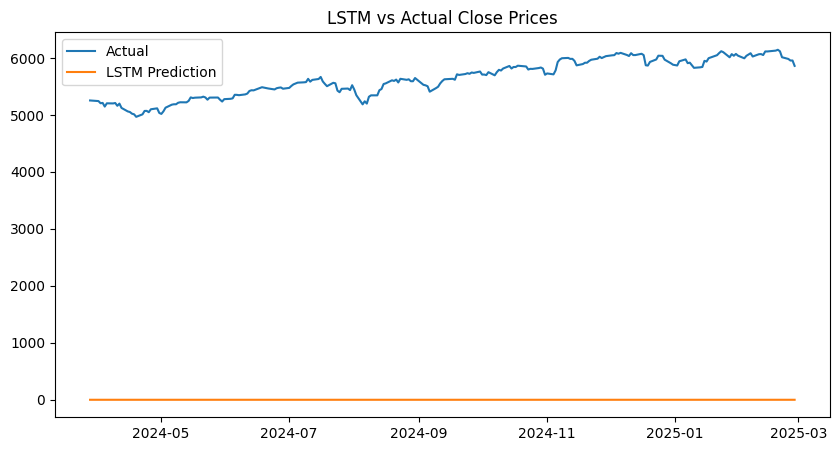

In [134]:
# Combining Both Models using Voting Classifier
from sklearn.linear_model import LogisticRegression

# Convert LSTM Predictions to Probability Scores
y_pred_proba = y_pred_scaled.flatten()

def weighted_ensemble(rf_preds, xgb_preds, lstm_preds, weights=[0.4, 0.4, 0.2]):
    return (weights[0] * rf_preds) + (weights[1] * xgb_preds) + (weights[2] * lstm_preds)

# Get individual model predictions
rf_proba = rf_model.predict_proba(test_df[predictors])[:, 1]
xgb_proba = xgb_model.predict_proba(test_df[predictors])[:, 1]
min_len = min(len(rf_proba), len(xgb_proba), len(y_pred_proba))
rf_proba = rf_proba[-min_len:]
xgb_proba = xgb_proba[-min_len:]
lstm_proba = y_pred_proba[-min_len:]  

# Compute the final ensemble prediction
ensemble_proba = weighted_ensemble(rf_proba, xgb_proba, lstm_proba)
ensemble_predictions = (ensemble_proba >= 0.5).astype(int)
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')
ensemble_model.fit(train_df[predictors], train_df['Target'])
ensemble_proba = ensemble_model.predict_proba(test_df[predictors])[:, 1]
ensemble_predictions = (ensemble_proba >= 0.5).astype(int)

print("Ensemble Model Precision Score:", precision_score(test_df["Target"], ensemble_predictions))

plt.figure(figsize=(10, 5))
plt.plot(test_df.index[window:], test_df["Close"].values[window:], label="Actual")
plt.plot(test_df.index[window:], y_pred.flatten(), label="LSTM Prediction")
plt.legend()
plt.title("LSTM vs Actual Close Prices")
plt.show()